In [1]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/applied-ai-engineering-samples/blob/main/genai-on-vertex-ai/vertex_evaluation_services/gemini-curate-evaluation-data/curate_new_evals.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fapplied-ai-engineering-samples%2Fmain%2Fgenai-on-vertex-ai/vertex_evaluation_services/gemini-curate-evaluation-data/curate_new_evals.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/applied-ai-engineering-samples/main/genai-on-vertex-ai/vertex_evaluation_services/gemini-curate-evaluation-data/curate_new_evals.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/applied-ai-engineering-samples/blob/main/genai-on-vertex-ai/vertex_evaluation_services/gemini-curate-evaluation-data/curate_new_evals.ipynb">
      <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

| | |
|-|-|
| Author(s) | [Ken Lee](https://github.com/kenleejr) |
| Reviewers(s) | [Abhishek Bhagwat](https://github.com/Abhishekbhagwat)|
| Last updated | 2024-10-07 |

Deploying a chatbot or retrieval augmented generation (RAG) application to real users provides a wealth of valuable data.  User queries reveal insights into their needs, the products they engage with, and the effectiveness of the chatbot itself. This data is crucial for both understanding your users and continuously evaluating the performance of your deployed system.

![image_link](./cluster_diagram.png)


This notebook demonstrates how to leverage Gemini to accelerate the analysis and summarization of real user queries from a production RAG system or chatbot. By analyzing these queries, we can identify a representative set of questions to form an evaluation dataset, establishing a foundation for continuous evaluation.


This process aims to answer the following questions:

- What general categories of questions are users asking? What problems are they encountering?

- What topics are prevalent in user conversations?

- What sentiments are users expressing?

Inspired by a [Weights and Biases article](https://wandb.ai/wandbot/wandbot-eval/reports/How-to-Evaluate-an-LLM-Part-1-Building-an-Evaluation-Dataset-for-our-LLM-System--Vmlldzo1NTAwNTcy), this notebook extends those concepts by utilizing Gemini's capabilities.  Gemini's large context window allows for rapid exploratory data analysis (EDA) of clustered questions, even with extensive datasets, facilitating efficient metadata extraction and informed selection of an evaluation dataset.  This, in turn, enables the construction of a robust and representative evaluation set for the RAG system.

# 🎬 Getting Started

The following steps are necessary to run this notebook, no matter what notebook environment you're using.

If you're entirely new to Google Cloud, [get started here](https://cloud.google.com/docs/get-started).



### Google Cloud Permissions

**To run the complete Notebook, including the optional section, you will need to have the [Owner role](https://cloud.google.com/iam/docs/understanding-roles) for your project.**

If you want to skip the optional section, you need at least the following [roles](https://cloud.google.com/iam/docs/granting-changing-revoking-access):
* **`roles/serviceusage.serviceUsageAdmin`** to enable APIs
* **`roles/iam.serviceAccountAdmin`** to modify service agent permissions
* **`roles/aiplatform.user`** to use AI Platform components

### Install Vertex AI SDK and Other Required Packages

In [ ]:
!pip install -qqq llama-index \
llama-index-llms-vertex \
llama-index-embeddings-vertex \
python-louvain \
tiktoken \
aiofiles \
annotated-types \
python-fasthtml

### Restart Runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

### Authenticate

If you're using Colab, run the code in the next cell. Follow the popups and authenticate with an account that has access to your Google Cloud [project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#identifying_projects).

If you're running this notebook somewhere besides Colab, make sure your environment has the right Google Cloud access. If that's a new concept to you, consider looking into [Application Default Credentials for your local environment](https://cloud.google.com/docs/authentication/provide-credentials-adc#local-dev) and [initializing the Google Cloud CLI](https://cloud.google.com/docs/authentication/gcloud). In many cases, running `gcloud auth application-default login` in a shell on the machine running the notebook kernel is sufficient.

More authentication options are discussed [here](https://cloud.google.com/docs/authentication).

In [ ]:
# Colab authentication.
import sys

if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()
    print('Authenticated')

### Set Google Cloud project information and Initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

Make sure to change `PROJECT_ID` in the next cell. You can leave the values for `REGION` unless you have a specific reason to change them.

In [2]:
import vertexai

PROJECT_ID = "<enter-your-project-id>"
REGION = "us-central1"
CSV_PATH = "./curate_evals_example.csv"
TEST_RUN = False
CLUSTERING_NEIGHBORHOOD_SIZE = 5

vertexai.init(
    project=PROJECT_ID,
    location=REGION
)

## Prepare the dataset

For this demo we are using a hypothetical dataset of questions about Google Cloud Services

In [3]:
import pandas as pd
import numpy as np
if TEST_RUN:
  df = pd.DataFrame({"Prompt": ["What is RAG?", "What is life?", "What is football?", "Who am I?"],
                   "answer": ["Retrieval Augmented Generation", "Love", "National Football League", "Human"]})
else:
  df = pd.read_csv(CSV_PATH)

In [4]:
df

Topic                                           Question
0    Compute Engine  How can I create a virtual machine instance on...
1    Compute Engine  "What are the different machine types availabl...
2    Compute Engine  "Can you explain the different pricing options...
3    Compute Engine  "How do I connect to my Compute Engine instanc...
4    Compute Engine  "What are preemptible instances, and how can t...
..              ...                                                ...
95  Cost Management  "How can I track and manage my Google Cloud co...
96  Cost Management  "What are the different pricing models for Goo...
97  Cost Management        "How can I optimize my Google Cloud costs?"
98  Cost Management  "What tools are available for cost management ...
99  Cost Management  "How can I set budgets and alerts for my Googl...

[100 rows x 2 columns]

### Dataset Preprocessing

Real world RAG systems have some anomalies in terms of the search queries - often, you will encounter single word queries or typos. In this step, we will preprocess and clean the dataset to remove the following types of queries:
- Very short and very long queries
- Near duplicates

In [5]:
df["question_len"] = df["Question"].apply(lambda x: len(x))

In [6]:
# Discard questions with too little or too many characters
df = df[(df.question_len > 5) & (df.question_len < 1000)]

In [7]:
df

Topic                                           Question  \
0    Compute Engine  How can I create a virtual machine instance on...   
1    Compute Engine  "What are the different machine types availabl...   
2    Compute Engine  "Can you explain the different pricing options...   
3    Compute Engine  "How do I connect to my Compute Engine instanc...   
4    Compute Engine  "What are preemptible instances, and how can t...   
..              ...                                                ...   
95  Cost Management  "How can I track and manage my Google Cloud co...   
96  Cost Management  "What are the different pricing models for Goo...   
97  Cost Management        "How can I optimize my Google Cloud costs?"   
98  Cost Management  "What tools are available for cost management ...   
99  Cost Management  "How can I set budgets and alerts for my Googl...   

    question_len  
0             63  
1            115  
2             77  
3             59  
4             65  
..           ...  
95            51  
96            66  
97            43  
98            63  
99            64  

[100 rows x 3 columns]

#### Visualize distribution of question lengths

<Axes: >

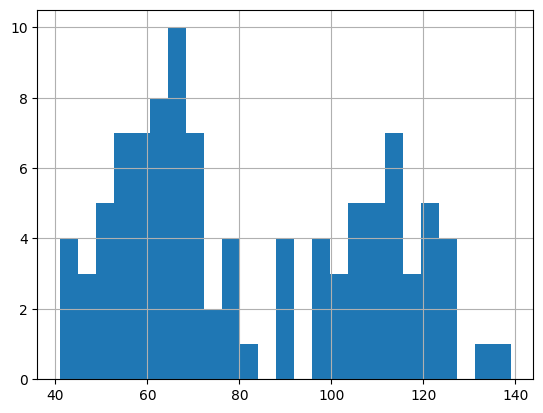

In [8]:
df.question_len.hist(bins=25)

## Generating the embeddings for the questions

Vertex AI embeddings models can generate optimized embeddings for various task types, such as document retrieval, question and answering, and fact verification. Task types are labels that optimize the embeddings that the model generates based on your intended use case.

In this example, we will set the `TASK_TYPE` as `RETRIEVAL_DOCUMENT` as this is used to generate embeddings that are optimized for information retrieval

Read more about the various `TASK_TYPE` offered by Vertex AI Embedding models [here](https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/task-types)

In [9]:
import asyncio
from tqdm.asyncio import tqdm_asyncio
from typing import List, Optional,  Tuple
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel
from google.cloud import storage
from vertexai.generative_models import GenerativeModel

async def embed_text_async(
    model: TextEmbeddingModel,
    texts: List[str] = ["banana muffins? ", "banana bread? banana muffins?"],
    task: str = "RETRIEVAL_DOCUMENT",
    dimensionality: Optional[int] = 768,):
    inputs = [TextEmbeddingInput(text, task) for text in texts]
    kwargs = dict(output_dimensionality=dimensionality) if dimensionality else {}
    embeddings = await model.get_embeddings_async(texts, **kwargs)
    return [embedding.values for embedding in embeddings]

# embedding model to use
model_name = "text-embedding-005"
embedding_model = TextEmbeddingModel.from_pretrained(model_name)

# embed questions from the dataset asynchronously
embedded_qs = await tqdm_asyncio.gather(*[embed_text_async(embedding_model,
                                        [x["Question"]]) for i, x in df.iterrows()])

100%|██████████| 100/100 [00:00<00:00, 302.49it/s]


In [10]:
embedded_qs_flattened = [q[0] for q in embedded_qs]

## Cluster the Questions

While various clustering algorithms can be applied, Louvain community detection is a particularly suitable choice for this task due to its speed and effectiveness.

### Vector-based Retrieval Clustering
1. Store your embedded question set in a vector index
2. Query the vector index with each question in the dataset, retrieving a topk-sized neighborhood of questions around the query question.
3. Form a graph of questions by adding an edge between the query question and each of the retrieved questions
4. Perform Louvain or Leiden community detection on the graph to create clusters of questions

In [11]:
from llama_index.core import (
    VectorStoreIndex,
    Settings,
    SimpleDirectoryReader,
    load_index_from_storage,
    StorageContext,
    Document
)
from llama_index.llms.vertex import Vertex
from llama_index.embeddings.vertex import VertexTextEmbedding
from vertexai.generative_models import HarmCategory, HarmBlockThreshold
import networkx as nx
from community import community_louvain # pip install python-louvain
import google.auth
import google.auth.transport.requests

credentials = google.auth.default()[0]
request = google.auth.transport.requests.Request()
credentials.refresh(request)


query_list = df["Question"].tolist()
query_docs = [Document(text=t) for t in query_list] # To make it LlamaIndex compatible
embed_model = VertexTextEmbedding(credentials=credentials, model_name="text-embedding-005")
llm = Vertex(model="gemini-2.0-flash-001",
             temperature=0.2,
             max_tokens=8192,
             safety_settings={
                    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
                    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
                    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
                    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
        }
)
Settings.llm = llm
Settings.embed_model = embed_model


# Form a local vector index with all our questions
vector_index = VectorStoreIndex.from_documents(query_docs)
vector_retriever = vector_index.as_retriever(similarity_top_k=CLUSTERING_NEIGHBORHOOD_SIZE)


# Create a similarity graph
G = nx.Graph()

# Get a neighborhood of similar questions by querying the vector index
similar_texts = await tqdm_asyncio.gather(*[vector_retriever.aretrieve(text) for i, text in enumerate(query_list)])

for i, text in enumerate(query_list):
  for s in similar_texts[i]:
    G.add_edge(text, s.text)

100%|██████████| 100/100 [00:01<00:00, 77.81it/s]


In [12]:
# Apply Louvain Community Detection
partition = community_louvain.best_partition(G)
df["cluster_idx"] = df["Question"].map(partition)

In [13]:
grouped_df = pd.DataFrame(df.groupby("cluster_idx")['Question'].apply(list)).reset_index()

In [14]:
grouped_df

cluster_idx                                           Question
0            0  [How can I create a virtual machine instance o...
1            1  ["What is BigQuery, and how can I use it to an...
2            2  ["What are the different tools available for d...
3            3  ["I need to increase the storage space on my C...
4            4  ["My application is experiencing performance i...
5            5  ["What are preemptible instances, and how can ...
6            6  ["What is Cloud Load Balancing, and how does i...
7            7  ["I need to transfer a large amount of data to...
8            8  ["I'm trying to train a machine learning model...
9            9  ["I'm concerned about the security of my sensi...

In [15]:
grouped_df["num_questions"] = grouped_df["Question"].apply(len)
grouped_df

cluster_idx                                           Question  \
0            0  [How can I create a virtual machine instance o...   
1            1  ["What is BigQuery, and how can I use it to an...   
2            2  ["What are the different tools available for d...   
3            3  ["I need to increase the storage space on my C...   
4            4  ["My application is experiencing performance i...   
5            5  ["What are preemptible instances, and how can ...   
6            6  ["What is Cloud Load Balancing, and how does i...   
7            7  ["I need to transfer a large amount of data to...   
8            8  ["I'm trying to train a machine learning model...   
9            9  ["I'm concerned about the security of my sensi...   

   num_questions  
0              9  
1              5  
2             12  
3             11  
4              8  
5             13  
6             12  
7              6  
8              4  
9             20

## Analyze Clusters Using Gemini

We can use Gemini to extract summaries, topics, relevant questions, sentiment or any other required information from the cluster.
This allows us to quickly identify higher level patterns about the various questions from users, understand different user problems and much more insightful information.

In [16]:
from vertexai.generative_models import GenerativeModel, GenerationConfig
from vertexai.generative_models import HarmCategory, HarmBlockThreshold
from llama_index.core.program import LLMTextCompletionProgram
from llama_index.core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from typing import Annotated
from enum import Enum
from annotated_types import Len

num_clusters = grouped_df.shape[0]

class Sentiment(Enum):
  POSITIVE = "positive"
  NEGATIVE = "negative"
  NEUTRAL = "neutral"

class ClusterSummary(BaseModel):
  '''A cluster summary, list of topics, most representative questions, and sentiment associated with a cluster of questions from chat sessions.'''
  summary_desc: str
  topics: List[str]
  most_representative_qs: Annotated[List[str], Len(3, 8)]
  sentiment: Sentiment


boring_prompt = """Please provide a brief summary which captures the nature of the given cluster of questions below in the form of "Questions concerning ____".
                  \n Cluster questions:
                  \n {questions_list}
                  \n The clusters titles should not be generic such as "Google Cloud AI" or "Gemini".
                  \n They need to be specific in order to distinguish the clusters from others which may be similar.
                  \n Also include a list of topic phrases which the questions address, the most representative questions of the cluster, and an overall sentiment. Be sure to follow a consistent format."""

movie_prompt = """You are an expert movie producer for famous movies.
                  \n Please provide a quipy, movie title which captures the essence of the given cluster of questions below.
                  \n Example:
                  \n How does RAG work on Vertex?
                  \n Where can I find documentation on Vertex AI Generative model API?
                  \n What are the pitfals of Gemini vs. Gemma?
                  \n Answer:
                  \n movie title: "Into the Vertex"
                  \n representative qs: How does RAG work on Vertex?
                  \n topics: Vertex AI, Vertex AI Generative Model
                  \n sentiment: neutral
                  \n Cluster questions:
                  \n {questions_list}
                  \n Also include a list of topic phrases which the questions address, the most representative questions of the cluster, and an overall sentiment. Be sure to follow a consistent format. """

async def summarize_cluster(questions: List[str]):
  questions_list = "\n".join(questions)
  llm_program = LLMTextCompletionProgram.from_defaults(
        output_parser=PydanticOutputParser(ClusterSummary),
        prompt_template_str=boring_prompt,
        verbose=True,
    )
  try:
    cluster_summary = await llm_program.acall(questions_list=questions_list)
  except Exception as e:
    print(e)
    return None
  return cluster_summary

In [17]:
# Summarize each cluster individually
cluster_summaries = await tqdm_asyncio.gather(*[summarize_cluster(q["Question"]) for idx, q in grouped_df.iterrows()])

100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


In [18]:
cluster_summaries

[ClusterSummary(summary_desc='Questions concerning the practical usage and troubleshooting of Google Compute Engine virtual machine instances, including instance creation, selection, connection, deletion recovery, clustering for high availability, firewall issues, and pricing.', topics=['Google Compute Engine', 'Virtual Machine Instances', 'Instance Creation', 'Machine Types', 'Pricing', 'SSH Connection', 'Instance Deletion Recovery', 'High Availability Clustering', 'Firewall Troubleshooting', 'Discounts'], most_representative_qs=['How can I create a virtual machine instance on Compute Engine?', 'What are the different machine types available on Compute Engine, and how do I choose the right one for my needs?', 'Can you explain the different pricing options for Compute Engine instances?', 'How do I connect to my Compute Engine instance using SSH?', 'I accidentally deleted my Compute Engine instance. How can I recover it?', 'I want to set up a cluster of Compute Engine instances for high

In [19]:
just_summaries = [c.summary_desc if c else None for c in cluster_summaries]

In [20]:
df_grouped_by_cluster = df.groupby("cluster_idx").agg("count")
df_grouped_by_cluster["cluster_summary"] = cluster_summaries
df_grouped_by_cluster["just_summary"] = just_summaries
df_grouped_by_cluster["questions_list"] = grouped_df["Question"]

In [21]:
from fasthtml.common import *
from fasthtml.fastapp import *
from random import sample
from fasthtml.components import Zero_md

tlink = Script(src="https://cdn.tailwindcss.com")
dlink = Link(rel="stylesheet", href="https://cdn.jsdelivr.net/npm/daisyui@4.11.1/dist/full.min.css")
app = FastHTML(hdrs=(dlink, tlink))

def Markdown(md, css = ''):
    css_template = Template(Style(css), data_append=True)
    return Zero_md(css_template, Script(md, type="text/markdown"))

def MarkdownWOutBackground(md: str):
    css = '.markdown-body {background-color: unset !important; color: unset !important;} .markdown-body table {color: black !important;}'
    markdown_wout_background = partial(Markdown, css=css)
    return markdown_wout_background(md)

def stat_card(num_questions: int):
  return Div(
    Div('Total Questions', cls='stat-title'),
    Div(f'{num_questions}', cls='stat-value'),
    cls='stat'
  )

def cluster_card(cluster_summary: ClusterSummary, questions_list: List[str]):
  if cluster_summary.sentiment == Sentiment.NEGATIVE:
    badge_color = "error"
  elif cluster_summary.sentiment == Sentiment.NEUTRAL:
    badge_color = "neutral"
  else:
    badge_color = "success"
  return Div(
              Div(
                  H2(cluster_summary.summary_desc, cls='card-title'),
                  Div(
                      stat_card(len(questions_list)),
                      Div(cluster_summary.sentiment, cls=f'badge badge-{badge_color}'),
                      cls="flex flex-row items-center"
                  ),
                  H4("Representative Questions:", cls="font-bold"),
                  Ul(
                      *[Li(q) for q in cluster_summary.most_representative_qs],
                      cls='list-disc list-inside mt-2'
                  ),
                  H4("Topics Discussed:", cls="font-bold"),
                  Ul(
                      *[Li(t) for t in cluster_summary.topics],
                      cls='list-disc list-inside mt-2'
                  ),
                  cls='card-body'
              ),
              cls='card bg-base-100 shadow-xl'
          )

@app.get("/")
def cluster_analysis():
    return Div(
              *[cluster_card(c, q) for c, q in zip(cluster_summaries, df_grouped_by_cluster["questions_list"])],
              cls="grid grid-cols-2 gap-2"
            )

## Gemini-generated Cluster Analysis

In [22]:
from starlette.testclient import TestClient
client = TestClient(app)
r = client.get("/")
show(r.content)

## Sample Questions from Each Cluster to create the Eval Dataset
- We can sample randomly proportional to each cluster's size
- Or we can take samples from the most representative questions Gemini identified

Probably need to sit down with an SME and compare both:

In [24]:
# Calculate the total number of questions
total_questions = df_grouped_by_cluster['question_len'].sum()

# Calculate the fraction of questions for each row
df_grouped_by_cluster['cluster_fraction'] = df_grouped_by_cluster['question_len'] / total_questions

# Function to sample from a list based on the fraction
def sample_questions(row, num_samples):
    return np.random.choice(row['questions_list'],
                            size=int(num_samples * row['cluster_fraction']),
                            replace=False).tolist()

# Specify the total number of samples you want
total_samples = 50

# Apply the sampling function to each row
df_grouped_by_cluster['proportional_sampled_questions'] = df_grouped_by_cluster.apply(lambda row: sample_questions(row, total_samples), axis=1)

# Unroll the DataFrame
df_grouped_by_cluster = df_grouped_by_cluster.reset_index()

# Print the resulting DataFrame
unrolled_proportional_df = df_grouped_by_cluster.apply(lambda x: pd.Series({
    'cluster_title': [x["just_summary"]] * len(x['proportional_sampled_questions']),
    'sampled_question': x['proportional_sampled_questions']
}), axis=1)

# Concatenate the series and reset the index
unrolled_proportional_df = pd.concat([unrolled_proportional_df['cluster_title'].explode(),
                         unrolled_proportional_df['sampled_question'].explode()],
                        axis=1).reset_index(drop=True)

In [25]:
unrolled_proportional_df

cluster_title  \
0   Questions concerning the practical usage and t...   
1   Questions concerning the practical usage and t...   
2   Questions concerning the practical usage and t...   
3   Questions concerning the practical usage and t...   
4   Questions concerning the practical application...   
5   Questions concerning the practical application...   
6   Questions concerning the practical application...   
7   Questions concerning the practical application...   
8   Questions concerning the practical application...   
9   Questions concerning the practical application...   
10  Questions concerning the practical application...   
11  Questions concerning the practical application...   
12  Questions concerning Google Cloud database ser...   
13  Questions concerning Google Cloud database ser...   
14  Questions concerning Google Cloud database ser...   
15  Questions concerning Google Cloud database ser...   
16  Questions concerning Google Cloud database ser...   
17  Questions concerning the monitoring, troublesh...   
18  Questions concerning the monitoring, troublesh...   
19  Questions concerning the monitoring, troublesh...   
20  Questions concerning the monitoring, troublesh...   
21  Questions concerning cost optimization strateg...   
22  Questions concerning cost optimization strateg...   
23  Questions concerning cost optimization strateg...   
24  Questions concerning cost optimization strateg...   
25  Questions concerning cost optimization strateg...   
26  Questions concerning cost optimization strateg...   
27  Questions concerning the automation of applica...   
28  Questions concerning the automation of applica...   
29  Questions concerning the automation of applica...   
30  Questions concerning the automation of applica...   
31  Questions concerning the automation of applica...   
32  Questions concerning the automation of applica...   
33  Questions concerning the practical aspects of ...   
34  Questions concerning the practical aspects of ...   
35  Questions concerning the practical aspects of ...   
36  Questions concerning practical challenges and ...   
37  Questions concerning practical challenges and ...   
38  Questions concerning securing Google Cloud res...   
39  Questions concerning securing Google Cloud res...   
40  Questions concerning securing Google Cloud res...   
41  Questions concerning securing Google Cloud res...   
42  Questions concerning securing Google Cloud res...   
43  Questions concerning securing Google Cloud res...   
44  Questions concerning securing Google Cloud res...   
45  Questions concerning securing Google Cloud res...   
46  Questions concerning securing Google Cloud res...   
47  Questions concerning securing Google Cloud res...   

                                     sampled_question  
0   "What are the different machine types availabl...  
1   "I accidentally deleted my Compute Engine inst...  
2   "Are there any discounts or sustained use disc...  
3   "I'm having trouble connecting to my Virtual M...  
4   "How can I use machine learning with BigQuery ...  
5   "What is BigQuery, and how can I use it to ana...  
6           "What is Dataflow, and how does it work?"  
7   "What are the different tools available for da...  
8   "How can I use Google Cloud to build a machine...  
9   "I need to monitor the performance of my deplo...  
10  "How can I use AutoML to build a machine learn...  
11  "How can I use Google Cloud to visualize my da...  
12  "What are the different storage options availa...  
13  "What database services are available on Googl...  
14  "I need to increase the storage space on my Co...  
15     "How can I scale my database on Google Cloud?"  
16  "How do I migrate my existing database to Goog...  
17  "How can I monitor the performance and logs of...  
18  "My application is experiencing performance is...  
19  "What is Cloud Logging, and how can I use it t...  
20  "I'm trying to troubleshoot an issue with my a...  
21  "What are 

In [26]:
df_grouped_by_cluster["gemini_representative_questions_len"] = df_grouped_by_cluster["cluster_summary"].apply(lambda x: len(x.most_representative_qs))
df_grouped_by_cluster["gemini_representative_questions"] = df_grouped_by_cluster["cluster_summary"].apply(lambda x: x.most_representative_qs)
# Print the resulting DataFrame
unrolled_gemini_df = df_grouped_by_cluster.apply(lambda x: pd.Series({
    'cluster_title': [x["just_summary"]] * len(x['gemini_representative_questions']),
    'representative_question': x['gemini_representative_questions']
}), axis=1)

# Concatenate the series and reset the index
unrolled_gemini_df = pd.concat([unrolled_gemini_df['cluster_title'].explode(),
                         unrolled_gemini_df['representative_question'].explode()],
                        axis=1).reset_index(drop=True)

In [27]:
unrolled_gemini_df

cluster_title  \
0   Questions concerning the practical usage and t...   
1   Questions concerning the practical usage and t...   
2   Questions concerning the practical usage and t...   
3   Questions concerning the practical usage and t...   
4   Questions concerning the practical usage and t...   
5   Questions concerning the practical usage and t...   
6   Questions concerning the practical usage and t...   
7   Questions concerning the practical application...   
8   Questions concerning the practical application...   
9   Questions concerning the practical application...   
10  Questions concerning the practical application...   
11  Questions concerning the practical application...   
12  Questions concerning the practical application...   
13  Questions concerning the practical application...   
14  Questions concerning the practical application...   
15  Questions concerning the practical application...   
16  Questions concerning the practical application...   
17  Questions concerning the practical application...   
18  Questions concerning Google Cloud database ser...   
19  Questions concerning Google Cloud database ser...   
20  Questions concerning Google Cloud database ser...   
21  Questions concerning Google Cloud database ser...   
22  Questions concerning Google Cloud database ser...   
23  Questions concerning Google Cloud database ser...   
24  Questions concerning Google Cloud database ser...   
25  Questions concerning the monitoring, troublesh...   
26  Questions concerning the monitoring, troublesh...   
27  Questions concerning the monitoring, troublesh...   
28  Questions concerning the monitoring, troublesh...   
29  Questions concerning the monitoring, troublesh...   
30  Questions concerning cost optimization strateg...   
31  Questions concerning cost optimization strateg...   
32  Questions concerning cost optimization strateg...   
33  Questions concerning cost optimization strateg...   
34  Questions concerning cost optimization strateg...   
35  Questions concerning cost optimization strateg...   
36  Questions concerning the automation of applica...   
37  Questions concerning the automation of applica...   
38  Questions concerning the automation of applica...   
39  Questions concerning the automation of applica...   
40  Questions concerning the automation of applica...   
41  Questions concerning the automation of applica...   
42  Questions concerning the automation of applica...   
43  Questions concerning the automation of applica...   
44  Questions concerning the practical aspects of ...   
45  Questions concerning the practical aspects of ...   
46  Questions concerning the practical aspects of ...   
47  Questions concerning the practical aspects of ...   
48  Questions concerning practical challenges and ...   
49  Questions concerning practical challenges and ...   
50  Questions concerning practical challenges and ...   
51  Questions concerning practical challenges and ...   
52  Questions concerning securing Google Cloud res...   
53  Questions concerning securing Google Cloud res...   
54  Questions concerning securing Google Cloud res...   
55  Questions concerning securing Google Cloud res...   
56  Questions concerning securing Google Cloud res...   
57  Questions concerning securing Google Cloud res...   
58  Questions concerning securing Google Cloud res...   
59  Questions concerning securing Google Cloud res...   

                              representative_question  
0   How can I create a virtual machine instance on...  
1   What are the different machine types available...  
2   Can you explain the different pricing options ...  
3   How do I connect to my Compute Engine instance...  
4   I accidentally deleted my Compute Engine insta...  
5   I want to set up a cluster of Compute Engine i...  
6   I'm having trouble connecting to my Virtual Ma...  
7   What is BigQuery, and how can I use it to anal...  
8   I have a large dataset that I want to analyze ...  
9 

### Save Results to CSV
- We do need to obtain ground truth answers
- But we can be confident we are putting the effort towards relevant, representative questions

In [28]:
unrolled_gemini_df.to_csv("representative_eval_questions.csv")

## Conclusion

With this notebook you can go from a mass of user queries from a RAG system and get immediate insights into the types of queries people are asking with useful clusters of queries described and analyzed by Gemini. This analysis can help inform decisions around how to improve the RAG system or it may highlight other issues in the business or product beyond what the chatbot can address. Finally, you can sample queries from these clusters to get a representative set of evaluation questions with which you can use to continuously evaluate the RAG system over time.

As a next step will be to take this set of representative questions and obtain ground truth from users or subject matter experts and then evaluating performance using a service like [Vertex AI Evaluation Service](https://cloud.google.com/vertex-ai/generative-ai/docs/models/evaluation-overview).